In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
from diffusers import DDPMPipeline
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
def show_images(x):
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_gird(images, size=64):
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

In [28]:
butterfly_pipeline = DDPMPipeline.from_pretrained("/data_disk/dyy/butterfly").to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /data_disk/dyy/butterfly: Error no file named diffusion_pytorch_model.safetensors found in directory /data_disk/dyy/butterfly.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [29]:
#crate 8 images
images = butterfly_pipeline(batch_size=8).images

  0%|          | 0/1000 [00:00<?, ?it/s]

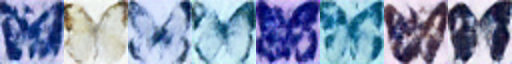

In [30]:
make_gird(images)

# Training

In [31]:
import torchvision
from datasets import load_dataset
from torchvision import transforms
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = "cuda" if torch.cuda.is_available() else "cpu"


# Step1:Download a training dataset

In [32]:
#表示训练集
dataset = load_dataset("/data_disk/dyy/smithsonian_butterflies_subset", split='train')
#查看文件路径是否存在
image_size = 32
batch_size = 64
#随便拿出一张来看看
dataset[0:2]['image']

Repo card metadata block was not found. Setting CardData to empty.


[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x283>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x179>]

In [33]:
#数据增强
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #归一化
    transforms.Normalize([0.5], [0.5])  #映射到(-1,1)
])


#预处理图像,并将其转变为RGB张量
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples['image']]
    return {'images': images}


dataset.set_transform(transform)  #这里调用了自定义的transform函数

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

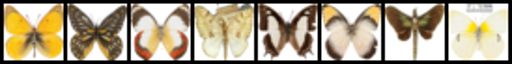

In [34]:
#去一个batch的images,看看是什么样子
xb_visualize = next(iter(train_dataloader))['images'].to(device)[:8]

show_images(xb_visualize).resize((8 * 64, 64), resample=Image.BICUBIC)

# Step2.Define the Scheduler


In [35]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=2000)
noise_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.31.0.dev0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 2000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

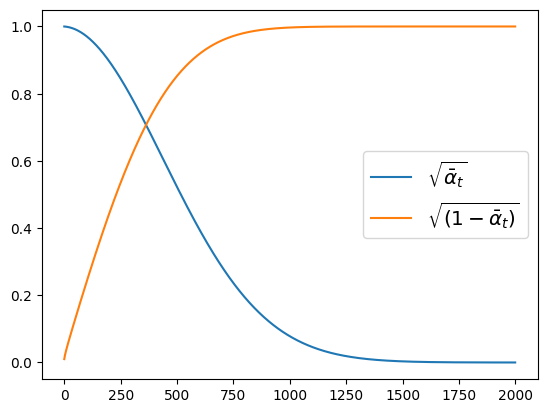

In [36]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");
#这张图说明在前向传播过程中,最终变成均值为0,方差为1的正态分布

Noise X Shape torch.Size([8, 3, 32, 32])


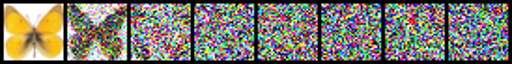

In [37]:
# 可视化噪声
timesteps = torch.linspace(0, 1999, 8).long().to(device)
noise = torch.randn_like(xb_visualize)  #加 mean=0 variance=1 的噪声

noisy_xb = noise_scheduler.add_noise(xb_visualize, noise, timesteps)
print('Noise X Shape', noisy_xb.shape)

show_images(noisy_xb).resize((8 * 64, 64), resample=Image.BICUBIC)

# Step3:Define Model UNet

In [38]:
from diffusers import UNet2DModel

#Create a model
model = UNet2DModel(
    sample_size=image_size,  #输入图像的大小
    in_channels=3,  #输入图像的通道数
    out_channels=3,  #输出图像的通道数
    layers_per_block=2,  #每一个block中有2个卷积层
    block_out_channels=(64, 128, 128, 256),  #每一个block的输出通道数
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [39]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

# Step4:Create a  Training Loop

In [40]:
noise_scheduler = DDPMScheduler(
    num_train_timesteps=2000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="squaredcos_cap_v2",
)

#Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch['images'].to(device)
        # sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        batch_size = clean_images.shape[0]

        #sample some random timesteps for each image ->每个图片都随机采样一个时间步
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (batch_size,), device=clean_images.device
        ).long()
        #add noise to the clean images according to the noise magnitude at ea ch timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        #Get model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]  #返回一个tuple

        #Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        #Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f'Epoch:{epoch + 1}, Loss:{loss_last_epoch:.4f}')



Epoch:5, Loss:0.1581
Epoch:10, Loss:0.1158
Epoch:15, Loss:0.1007
Epoch:20, Loss:0.0876
Epoch:25, Loss:0.0768
Epoch:30, Loss:0.0813


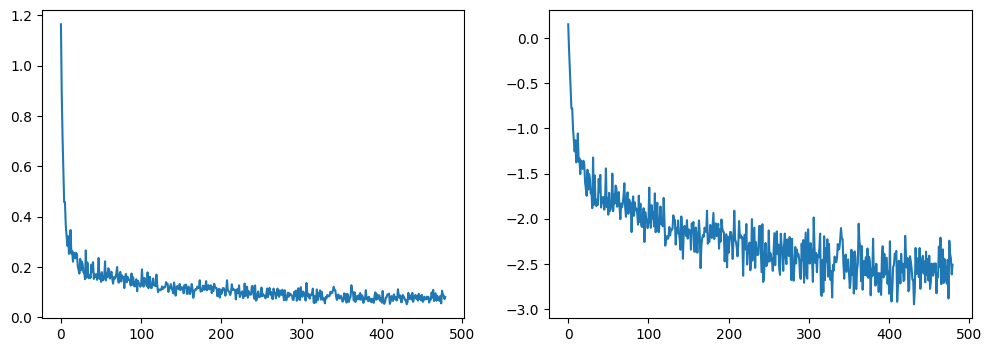

In [45]:
fig , axs=plt.subplots(1,2,figsize=(12,4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()



# Step5:Generate Images

In [52]:
#1.create a pipeline
from diffusers import DDPMPipeline

image_pipe=DDPMPipeline(unet=model,scheduler=noise_scheduler)

pipeline_output=image_pipe()
pipeline_output.images[0]

TypeError: DDPMPipeline.__init__() got an unexpected keyword argument 'epoch'

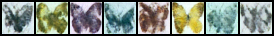

In [55]:
# 2. writing a sampling loop
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)